# **Import and Install**

In [1]:
!pip install torch torchvision transformers

     |████████████████████████████████| 4.0 MB 9.7 MB/s 
     |████████████████████████████████| 77 kB 8.9 MB/s 
     |████████████████████████████████| 880 kB 64.7 MB/s 
     |████████████████████████████████| 6.6 MB 46.2 MB/s 
     |████████████████████████████████| 596 kB 54.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=c30a152bb856879369359043a98e0e2ca9b4fae45108b1082234bcfc97f6c6ab
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import nltk
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from transformers import AdamW
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from LoadData import LoadDataAndProcessing
from RumourDataSet import RumourDataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Build The Model**

In [6]:
# Parameters setting

BATCH_SIZE = 8
NUM_WORKERS = 2
MAX_LEN = 450
num_labels = 2
hidden_dropout_prob = 0.3
learning_rate = 2e-5
weight_decay = 1e-2

gpu = 0 # gpu ID
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# If the inputs are already processed on local

train_input_file = "/content/drive/MyDrive/NLP/data/train_input.pickle"
dev_input_file = "/content/drive/MyDrive/NLP/data/dev_input.pickle"

train_input = pickle.load(open(train_input_file, "rb", -1))
dev_input = pickle.load(open(dev_input_file, "rb", -1))

#Creating instances of training and development set
#maxlen sets the maximum length a sentence can have
#any sentence longer than this length is truncated to the maxlen size
train_set = RumourDataset(data = train_input, maxlen = MAX_LEN)
dev_set = RumourDataset(data = dev_input, maxlen = MAX_LEN)

#Creating intsances of training and development dataloaders
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, 
                          collate_fn=train_set.create_mini_batch, 
                          num_workers = NUM_WORKERS, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size = BATCH_SIZE, 
                        collate_fn=dev_set.create_mini_batch, 
                        num_workers = NUM_WORKERS, shuffle=True)

print("Done preprocessing training and development data.")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Done preprocessing training and development data.


In [12]:
# # else

# train_file = "/content/drive/MyDrive/NLP/data/train_data_prepared.json"
# dev_file = "/content/drive/MyDrive/NLP/data/dev_data_prepared.json"

# load_twitter_train_data = LoadDataAndProcessing(train_file)
# load_twitter_dev_data = LoadDataAndProcessing(dev_file)

# train_input = load_twitter_train_data.prepareDataset()
# dev_input = load_twitter_dev_data.prepareDataset()

# train_set = RumourDataset(data = train_input, maxlen = MAX_LEN)
# dev_set = RumourDataset(data = dev_input, maxlen = MAX_LEN)

# train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, 
#                           collate_fn=train_set.create_mini_batch, 
#                           num_workers = NUM_WORKERS, shuffle=True)
# dev_loader = DataLoader(dev_set, batch_size = BATCH_SIZE, 
#                         collate_fn=dev_set.create_mini_batch, 
#                         num_workers = NUM_WORKERS, shuffle=True)

# print("Done preprocessing training and development data.")

In [13]:
# Load the model
print("Creating the rumour classifier, initialised with pretrained BERT-BASE parameters...")
config = BertConfig.from_pretrained("bert-base-uncased", 
                                    num_labels=num_labels, hidden_dropout_prob=hidden_dropout_prob)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
model.to(device)
print("Done creating the rumour classifier.")

Creating the rumour classifier, initialised with pretrained BERT-BASE parameters...


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Done creating the rumour classifier.


In [14]:
# Prepare optimizer and schedule (linear warmup and decay)
# set the bias and LayerNorm.weight 
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not 
                    any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if 
                    any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

#optimizer = AdamW(model.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# **Trian and Evaluate the Model**

In [15]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for i, batch in enumerate(dataloader):

        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in batch]

        optimizer.zero_grad()

        output = model(input_ids=tokens_tensors, 
                       token_type_ids=segments_tensors, 
                       attention_mask=masks_tensors, labels=labels)

        y_pred_prob = output[1]
        y_pred_label = y_pred_prob.argmax(dim=1)

        loss = criterion(y_pred_prob.view(-1, 2), labels.view(-1))

        acc = ((y_pred_label == labels.view(-1)).sum()).item()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

        if i % 200 == 0:
            print("Iteration {} complete. Loss:{}, Accuracy:{}".format(
                i, epoch_loss / (i+1), epoch_acc / ((i+1)*len(labels))))

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader.dataset)

def evaluate(model, iterator, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    TP, TN, FN, FP = 0, 0, 0 ,0

    with torch.no_grad():
        for _, batch in enumerate(iterator):
            tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in batch]

            output = model(input_ids=tokens_tensors, 
                           token_type_ids=segments_tensors, 
                           attention_mask=masks_tensors, labels=labels)
            y_pred_label = output[1].argmax(dim=1)
            loss = output[0]
            acc = ((y_pred_label == labels.view(-1)).sum()).item()

            epoch_loss += loss.item()
            epoch_acc += acc

            # TP += ((y_pred_label == 1) & (labels.view(-1) == 1)).cpu().sum()
            # TN += ((y_pred_label == 0) & (labels.view(-1) == 0)).cpu().sum()
            # FN += ((y_pred_label == 0) & (labels.view(-1) == 1)).cpu().sum()
            # FP += ((y_pred_label == 1) & (labels.view(-1) == 0)).cpu().sum()

            # # Calculate the f1 weighted score
            # p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, pos_label=1, average="binary")

    # p = TP / (TP + FP)
    # r = TP / (TP + FN)
    # F1 = 2 * r * p / (r + p)

    return epoch_loss / len(iterator), epoch_acc / len(iterator.dataset)

In [16]:
train_acc_list = []
train_loss_list = []
dev_acc_list = []
dev_loss_list = []

best_acc = 0
EPOCHS = 20
best_ep = 0
for ep in range(EPOCHS):
    print("EPOCH {} ------------------------------------------------------".format(ep+1))
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    print("EPOCH {}:".format(ep+1), "Mean train loss: ", train_loss, "\t", "Mean train acc:", train_acc)
    dev_loss, dev_acc = evaluate(model, dev_loader, device)
    print("EPOCH {}:".format(ep+1), "Mean dev loss: ", dev_loss, "\t", "Mean dev acc:", dev_acc)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    dev_acc_list.append(dev_acc)
    dev_loss_list.append(dev_loss)

    if dev_acc > best_acc:
      print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
      best_acc = dev_acc
      best_ep = ep
      torch.save(model.state_dict(), 'sstcls_{}.dat'.format(ep))
    
    print("********************************************************************************")


EPOCH 1 ------------------------------------------------------
Iteration 0 complete. Loss:0.7072023749351501, Accuracy:0.625
EPOCH 1: Mean train loss:  0.450709089028592 	 Mean train acc: 0.7955271565495208
EPOCH 1: Mean dev loss:  0.3805611977244125 	 Mean dev acc: 0.8141263940520446
Best development accuracy improved from 0 to 0.8141263940520446, saving model...
********************************************************************************
EPOCH 2 ------------------------------------------------------
Iteration 0 complete. Loss:0.28800687193870544, Accuracy:0.875
EPOCH 2: Mean train loss:  0.34014427986908324 	 Mean train acc: 0.8198083067092652
EPOCH 2: Mean dev loss:  0.3055594754131401 	 Mean dev acc: 0.8643122676579925
Best development accuracy improved from 0.8141263940520446 to 0.8643122676579925, saving model...
********************************************************************************
EPOCH 3 ------------------------------------------------------
Iteration 0 complete.

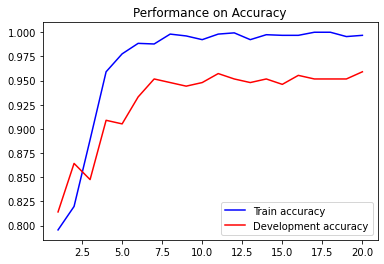

In [17]:
epochs = range(1, EPOCHS+1)
plt.plot(epochs, train_acc_list, 'b', label = 'Train accuracy')
plt.plot(epochs, dev_acc_list, 'r', label = 'Development accuracy')
plt.title('Performance on Accuracy')
plt.legend()
plt.savefig("Accuracy.png")
plt.show()

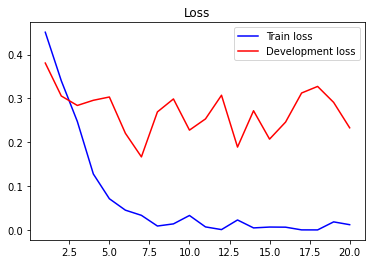

In [18]:
epochs = range(1, EPOCHS+1)
plt.plot(epochs, train_loss_list, 'b', label = 'Train loss')
plt.plot(epochs, dev_loss_list, 'r', label = 'Development loss')
plt.title('Loss')
plt.legend()
plt.savefig("Loss.png")
plt.show()

# **Devset Prediction**

In [64]:
# If the inputs are already processed on local

dev_to_predict_input_file = "/content/drive/MyDrive/NLP/data/dev_to_predict_input.pickle"

dev_to_predict_input = pickle.load(open(dev_to_predict_input_file, "rb", -1))

In [65]:
# # else

# dev_to_predict_input_file = "/content/drive/MyDrive/NLP/data/dev_data_to_predict_input.json"

# load_twitter_dev_to_predict_data = LoadDataAndProcessing(dev_to_predict_input_file)

# dev_to_predict_input = load_twitter_dev_to_predict_data.prepareDataset()

In [66]:
dev_to_predict_set = RumourDataset(data = dev_to_predict_input, maxlen = MAX_LEN)
dev_to_predict_loader = DataLoader(dev_to_predict_set, collate_fn=dev_to_predict_set.create_mini_batch, 
                         batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)

In [67]:
def predict(net, test_loader, model_file=None):
    # load weight
    if model_file != None:
      net.load_state_dict(torch.load(model_file))
    
    predictions = []
    
    for _, batch in enumerate(test_loader):
      tokens_tensors, segments_tensors, masks_tensors = [t.to(device) for t in batch]

      output = model(input_ids=tokens_tensors, 
                      token_type_ids=segments_tensors, 
                      attention_mask=masks_tensors)
      probs = output[0].argmax(dim=1)
      soft_probs = (probs > 0.5).long()
      predictions.extend(soft_probs.cpu().numpy().squeeze())
    
    return predictions

In [68]:
model_file = "sstcls_{}.dat".format(best_ep)
predictions = predict(model, dev_to_predict_loader, model_file)
len(predictions)

538

In [69]:
pred = pd.DataFrame(data=predictions, columns=['Predicted']).reset_index()
pred = pred.rename(columns={'index': 'Id'})
print(pred)

pred.to_csv('dev_prediction.csv', index = False)

      Id  Predicted
0      0          0
1      1          0
2      2          0
3      3          0
4      4          0
..   ...        ...
533  533          1
534  534          0
535  535          1
536  536          0
537  537          0

[538 rows x 2 columns]


# **Testset Prediction**

In [74]:
# If the inputs are already processed on local

test_input_file = "/content/drive/MyDrive/NLP/data/test_input.pickle"

test_input = pickle.load(open(test_input_file, "rb", -1))

In [75]:
# # else

# test_file = "/content/drive/MyDrive/NLP/data/test_data_prepared.json"

# load_twitter_test_data = LoadDataAndProcessing(test_file)

# test_input = load_twitter_test_data.prepareDataset()

In [76]:
test_set = RumourDataset(data = test_input, maxlen = MAX_LEN)
test_loader = DataLoader(test_set, collate_fn=test_set.create_mini_batch, 
                         batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)

In [77]:
model_file = "sstcls_{}.dat".format(best_ep)
predictions = predict(model, test_loader, model_file)
len(predictions)

558

In [78]:
pred = pd.DataFrame(data=predictions, columns=['Predicted']).reset_index()
pred = pred.rename(columns={'index': 'Id'})
print(pred)

pred.to_csv('test_prediction.csv', index = False)

      Id  Predicted
0      0          0
1      1          0
2      2          0
3      3          0
4      4          1
..   ...        ...
553  553          0
554  554          0
555  555          1
556  556          0
557  557          0

[558 rows x 2 columns]


In [79]:
with open('Parameters.txt', 'w') as f:
    f.write("BATCH_SIZE = {},\n".format(BATCH_SIZE) +
            "NUM_WORKERS = {},\n".format(NUM_WORKERS) +
            "MAX_LEN = {},\n".format(MAX_LEN) +
            "hidden_dropout_prob = {},\n".format(hidden_dropout_prob) +
            "learning_rate = {},\n".format(learning_rate) +
            "weight_decay = {}".format(weight_decay))

# **Covid set Prediction**

In [70]:
# For task 2 covid data

covid_input_file = "/content/drive/MyDrive/NLP/data/covid_input.pickle"

covid_input = pickle.load(open(covid_input_file, "rb", -1))

In [71]:
covid_set = RumourDataset(data = covid_input, maxlen = MAX_LEN)
covid_loader = DataLoader(covid_set, collate_fn=covid_set.create_mini_batch, 
                         batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)

In [72]:
model_file = "sstcls_{}.dat".format(best_ep)
predictions = predict(model, covid_loader, model_file)
len(predictions)

13454

In [73]:
pred = pd.DataFrame(data=predictions, columns=['Predicted']).reset_index()
pred = pred.rename(columns={'index': 'Id'})
print(pred)

pred.to_csv('covid_prediction.csv', index = False)

          Id  Predicted
0          0          0
1          1          0
2          2          0
3          3          0
4          4          0
...      ...        ...
13449  13449          0
13450  13450          1
13451  13451          1
13452  13452          0
13453  13453          0

[13454 rows x 2 columns]


# Empty the memory

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=bf6297d5882182784a1d000bfd3b2d459e6770ac5611df0f9254a37ed5f14996
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


Gen RAM Free: 11.6 GB  |     Proc size: 1.0 GB
GPU RAM Free: 15106MB | Used: 3MB | Util   0% | Total     15109MB


In [ ]:
!ps -aux|grep python

root          30  0.5  0.0      0     0 ?        Z    06:59   0:04 [python3] <defunct>
root          31  0.0  0.3 158256 41376 ?        S    06:59   0:00 python3 /usr/local/bin/colab-fileshim.py
root          56  0.4  0.4 202440 61064 ?        Sl   06:59   0:03 /usr/bin/python3 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root         316  0.0  0.0  18380  2960 ?        S    06:59   0:00 bash -c tail -n +0 -F "/root/.config/Google/DriveFS/Logs/drive_fs.txt" | python3 /opt/google/drive/drive-filter.py > "/root/.config/Google/DriveFS/Logs/timeouts.txt" 
root         319  0.0  0.0  31272  9380 ?        S    06:59   0:00 python3 /opt/google/drive/drive-filter.py
root         506  7.5 42.2 31615000 5617240 ?    Ssl  07:07   0:15 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-8598b9a0-c7fd-45c2-bbb1-36144b25e38e.json
root         524  0.2  0.1 127700 16380 ?    

In [ ]:
!kill -9 506